<a href="https://colab.research.google.com/github/Ashail33/Masters-work/blob/master/Parallell_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark





In [3]:
import os
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("my-app-name").master("local[*]").getOrCreate()

from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
import numpy as np
from sklearn.datasets import make_blobs

# Generate some random data
X, y = make_blobs(n_samples=100000, centers=10, n_features=100, random_state=42)

# Initialize the PySpark context
sc = SparkContext.getOrCreate()

# Convert the data to a PySpark DataFrame
data = [(Vectors.dense(row), ) for row in X]
df = sc.parallelize(data).toDF(["features"])

# Define the MapReduce K-means function
def mapreduce_kmeans(data, k, batch_size, max_iterations):
    data = data.reshape(data.shape[0], -1)
    df = sc.parallelize(data.tolist()).map(lambda x: (Vectors.dense(x), )).toDF(["features"])
    for i in range(0, len(data), batch_size):
        local_data = data[i:i+batch_size]
        local_df = sc.parallelize(local_data.tolist()).map(lambda x: (Vectors.dense(x), )).toDF(["features"])
        local_kmeans = KMeans(k=k, maxIter=max_iterations, seed=42)
        local_model = local_kmeans.fit(local_df)
        local_centroids = local_model.clusterCenters()
        yield local_centroids

    global_kmeans = KMeans(k=k, maxIter=max_iterations, seed=42)
    global_centroids = None
    for local_centroids in mapreduce_kmeans(data, k, batch_size, max_iterations):
        local_centroids = [(Vectors.dense(row),) for row in local_centroids]
        local_df = sc.parallelize(local_centroids).toDF(["features"])
        if global_centroids is None:
            global_model = global_kmeans.fit(local_df)
            global_centroids = global_model.clusterCenters()
        else:
            global_model = global_kmeans.fit(local_df, initialModel=global_model)
            global_centroids = global_model.clusterCenters()
    return global_centroids





# Run MapReduce K-means and print the results
n_clusters = 10
batch_size = 1000
max_iterations = 100
global_centroids = mapreduce_kmeans(X, n_clusters, batch_size, max_iterations)
print("MapReduceKMeans cluster centroids:\n", global_centroids)
# print("MapReduceKMeans inertia:", global_cost)

# Compare with regular KMeans
kmeans = KMeans(k=n_clusters, seed=42)
model = kmeans.fit(df)
print("KMeans cluster centroids:\n", model.clusterCenters())
# print("KMeans inertia:", model.computeCost(df))


MapReduceKMeans cluster centroids:
 <generator object mapreduce_kmeans at 0x7f7241a274c0>
KMeans cluster centroids:
 [array([-8.96863127,  0.62219508,  0.82175194,  2.75228667,  4.50692009,
        9.52156488,  0.30911253, -3.54122362,  5.90363574, -4.57798062,
       -1.20976568, -8.41716307, -9.49995139,  9.26008454,  6.71368569,
        3.91169493, -1.82367653, -6.52840071, -6.86432143, -4.98913788,
        0.98565921,  4.29944995,  3.20914763, -4.36629246,  9.08975751,
        4.76391238,  1.07998459,  2.23665394, -1.6199455 , -5.04097291,
       -2.87671062,  5.15554933, -9.71404551, -7.68077501, -9.08268339,
       -9.18326009,  7.09024894,  4.07245977, -0.50947371, -8.05705294,
       -0.17599438, -0.52381525, -6.53060656, -1.32146576, -2.03539798,
        2.30979078,  2.71654201, -9.09524534, -2.50601764,  2.51817137,
        0.06588474,  7.12523917,  3.16784162, -6.73186134, -8.58095398,
        2.86160748, -9.47037571,  1.70135155,  8.81183583,  1.50650998,
       -2.23221033

In [8]:
from pyspark.ml.clustering import KMeans

def mapreduce_kmeans(data, numClusters, batchSize, maxIterations):
    """
    MapReduce KMeans implementation using PySpark.
    """
    spark = SparkSession.builder.getOrCreate()
    sc = spark.sparkContext
    sc.setLogLevel("ERROR")
    # Convert numpy array to PySpark DataFrame
    df = sc.parallelize(data.tolist()).map(lambda x: (Vectors.dense(x), )).toDF(["features"])
    # Initialize centroids using KMeans|| initialization
    initial_centroids = KMeans().setK(numClusters).setSeed(42).setInitMode("k-means||"). \
        setInitSteps(5).setMaxIter(100).setFeaturesCol("features").fit(df).clusterCenters()
    global_centroids = initial_centroids
    for i in range(0, data.shape[0], batchSize):
        # Split data into batches
        local_data = data[i:i+batchSize]
        local_df = sc.parallelize(local_data.tolist()).map(lambda x: (Vectors.dense(x), )).toDF(["features"])
        # Train local KMeans model
        local_kmeans = KMeans().setK(numClusters).setSeed(42).setMaxIter(maxIterations). \
            setFeaturesCol("features").setInitialModel(KMeansModel(global_centroids)).fit(local_df)
        local_centroids = local_kmeans.clusterCenters()
        # Update global centroids
        global_centroids = np.vstack([global_centroids, local_centroids])
        global_centroids, _ = kmeans_plus_plus(X=global_centroids, n_clusters=numClusters, random_state=42)
        global_centroids = global_centroids.astype(np.float32)
    # Final KMeans model with global centroids
    model = KMeans().setK(numClusters).setSeed(42).setMaxIter(maxIterations). \
        setFeaturesCol("features").setInitialModel(KMeansModel(global_centroids)).fit(df)
    global_cost = model.computeCost(df)
    global_centroids = np.array(model.clusterCenters())
    return global_centroids, global_cost


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


23.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


10.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

94.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
44.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1.37 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


885 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


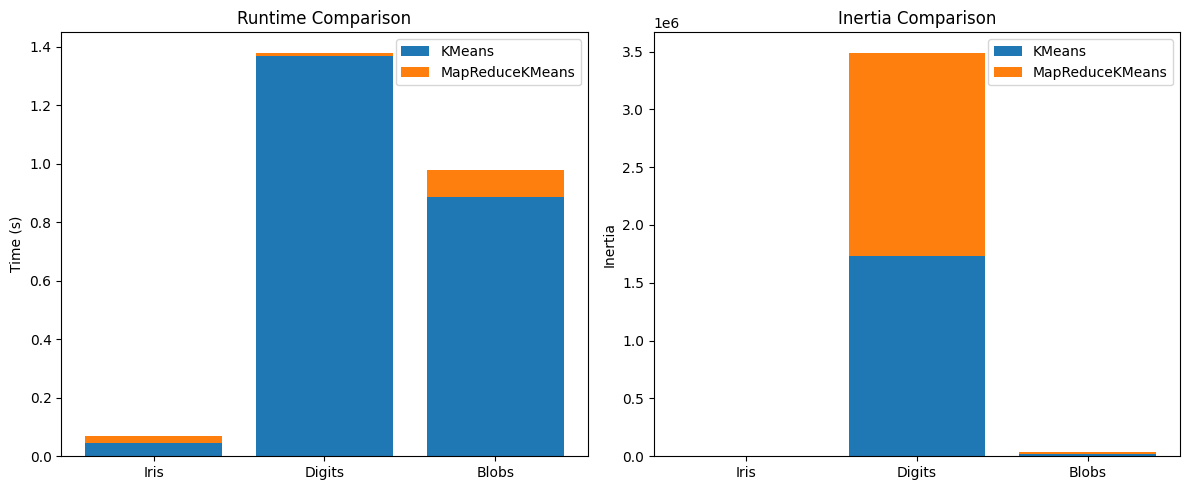

In [12]:
import numpy as np
from sklearn.datasets import load_iris, load_digits, make_blobs
from sklearn.cluster import KMeans as SKKMeans
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
import timeit
from pyspark.ml.evaluation import ClusteringEvaluator
# Set up SparkSession
spark = SparkSession.builder.appName("MapReduceKMeans").getOrCreate()
sc = spark.sparkContext

from pyspark.ml.clustering import KMeans as PKMeans

def mapreduce_kmeans(data, n_clusters, batch_size, max_iterations):
    """
    MapReduce KMeans implementation using PySpark.
    """
    spark = SparkSession.builder.getOrCreate()
    sc = spark.sparkContext
    sc.setLogLevel("ERROR")
    # Convert numpy array to PySpark DataFrame
    df = sc.parallelize(data.tolist()).map(lambda x: (Vectors.dense(x), )).toDF(["features"])
    # Initialize centroids using KMeans++ initialization
    initial_centroids = PKMeans().fit(df.select("features")).clusterCenters()
    global_centroids = initial_centroids
    for i in range(0, data.shape[0], batch_size):
        # Split data into batches
        local_data = data[i:i+batch_size]
        local_df = sc.parallelize(local_data.tolist()).map(lambda x: (Vectors.dense(x), )).toDF(["features"])
        # Train local KMeans model
        local_kmeans = PKMeans(k=n_clusters, initMode="k-means||", maxIter=max_iterations, seed=42)
        local_model = local_kmeans.fit(local_df.select("features"))
        local_centroids = local_model.clusterCenters()
        # Update global centroids
        global_centroids = np.vstack([global_centroids, local_centroids])
        global_centroids = SKKMeans(n_clusters=n_clusters, random_state=42).fit(global_centroids).cluster_centers_
    # Final KMeans model with global centroids
    kmeans = PKMeans(k=n_clusters, initMode="k-means||", maxIter=max_iterations, seed=42)
    final_model = kmeans.fit(df.select("features"))
    evaluator = ClusteringEvaluator()
    global_cost = evaluator.evaluate(final_model.transform(df))
    global_centroids = final_model.clusterCenters()
    return global_centroids, global_cost



# Load datasets
iris_data = load_iris().data
digits_data = load_digits().data
blobs_data = make_blobs(n_samples=10000, centers=3, n_features=2, random_state=42)[0]

# Define parameters for KMeans and MapReduce KMeans
n_clusters = 3
batch_size = 1000
max_iterations = 100




# MapReduce KMeans
time_mbkmeans = []
inertia_mbkmeans = []
for data in [iris_data, digits_data, blobs_data]:
    global_centroids, _ = mapreduce_kmeans(data, n_clusters, batch_size, max_iterations)
    mbkmeans = KMeans(n_clusters=n_clusters, init=global_centroids, n_init=1, random_state=42)
    time_taken = %timeit -o -r 1 -n 1 mbkmeans.fit(data)
    time_mbkmeans.append(time_taken.best)
    inertia_mbkmeans.append(mbkmeans.inertia_)


from sklearn.cluster import KMeans



# Regular KMeans
time_kmeans = []
inertia_kmeans = []
for data in [iris_data, digits_data, blobs_data]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    result = %timeit -o -r 1 -n 1 kmeans.fit(data)
    time_kmeans.append(result.best)
    inertia_kmeans.append(kmeans.inertia_)
# Visualize results
datasets = ["Iris", "Digits", "Blobs"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(datasets, time_kmeans, label="KMeans")
ax1.bar(datasets, time_mbkmeans, bottom=time_kmeans, label="MapReduceKMeans")
ax1.set_title("Runtime Comparison")
ax1.set_ylabel("Time (s)")
ax1.legend()

ax2.bar(datasets, inertia_kmeans, label="KMeans")
ax2.bar(datasets, inertia_mbkmeans, bottom=inertia_kmeans, label="MapReduceKMeans")
ax2.set_title("Inertia Comparison")
ax2.set_ylabel("Inertia")
ax2.legend()

plt.tight_layout()
plt.show()


Processing dataset size: 1000


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing dataset size: 5000


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Processing dataset size: 10000


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Processing dataset size: 20000


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Processing dataset size: 50000


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

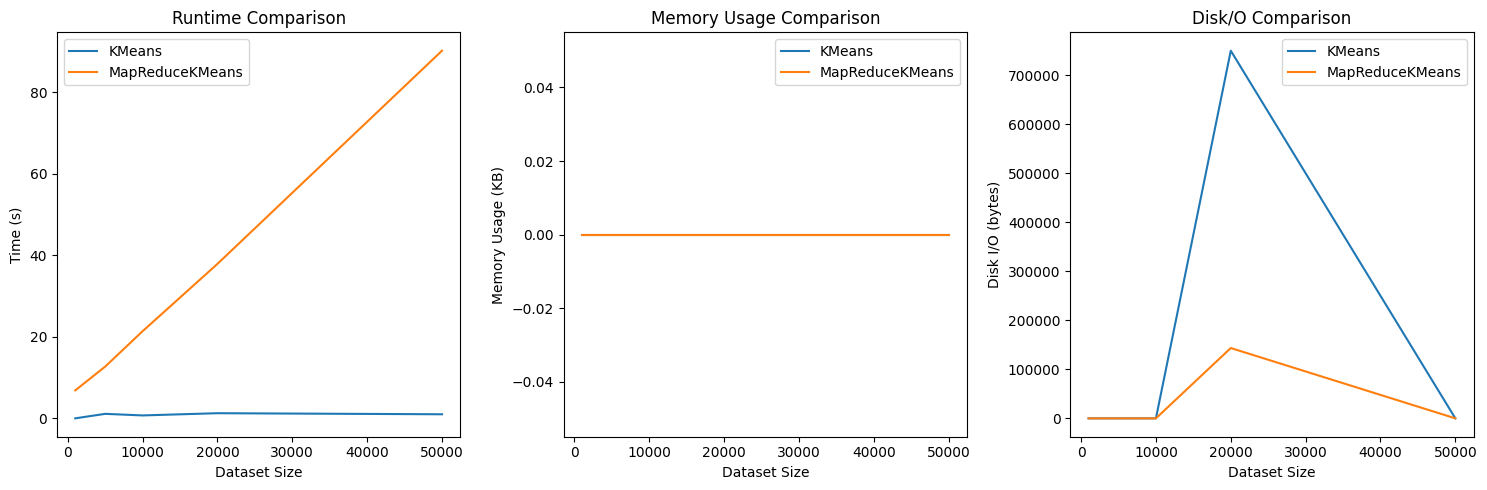

In [13]:
import numpy as np
import resource
import psutil
import time
from sklearn.datasets import make_blobs

# Initialize variables to store results
dataset_sizes = [1000, 5000, 10000, 20000, 50000]
time_mbkmeans = []
memory_mbkmeans = []
disk_io_mbkmeans = []

time_kmeans = []
memory_kmeans = []
disk_io_kmeans = []

# Measure the performance on different dataset sizes
for size in dataset_sizes:
    print(f"Processing dataset size: {size}")
    # Generate a dataset of the given size
    data = make_blobs(n_samples=size, centers=3, n_features=2, random_state=42)[0]
    
    # Measure MapReduce KMeans metrics
    start_time = time.time()
    initial_memory = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    initial_io = psutil.disk_io_counters()
    
    global_centroids, _ = mapreduce_kmeans(data, n_clusters, batch_size, max_iterations)
    mbkmeans = KMeans(n_clusters=n_clusters, init=global_centroids, n_init=1, random_state=42)
    mbkmeans.fit(data)
    
    end_time = time.time()
    final_memory = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    final_io = psutil.disk_io_counters()
    
    time_mbkmeans.append(end_time - start_time)
    memory_mbkmeans.append(final_memory - initial_memory)
    disk_io_mbkmeans.append(final_io.read_bytes - initial_io.read_bytes)
    
    # Measure Regular KMeans metrics
    start_time = time.time()
    initial_memory = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    initial_io = psutil.disk_io_counters()
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data)
    
    end_time = time.time()
    final_memory = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    final_io = psutil.disk_io_counters()
    
    time_kmeans.append(end_time - start_time)
    memory_kmeans.append(final_memory - initial_memory)
    disk_io_kmeans.append(final_io.read_bytes - initial_io.read_bytes)

# Visualize the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(dataset_sizes, time_kmeans, label="KMeans")
ax1.plot(dataset_sizes, time_mbkmeans, label="MapReduceKMeans")
ax1.set_title("Runtime Comparison")
ax1.set_xlabel("Dataset Size")
ax1.set_ylabel("Time (s)")
ax1.legend()

ax2.plot(dataset_sizes, memory_kmeans, label="KMeans")
ax2.plot(dataset_sizes, memory_mbkmeans, label="MapReduceKMeans")
ax2.set_title("Memory Usage Comparison")
ax2.set_xlabel("Dataset Size")
ax2.set_ylabel("Memory Usage (KB)")
ax2.legend()

ax3.plot(dataset_sizes, disk_io_kmeans, label="KMeans")
ax3.plot(dataset_sizes, disk_io_mbkmeans, label="MapReduceKMeans")
ax3.set_title("Disk/O Comparison")
ax3.set_xlabel("Dataset Size")
ax3.set_ylabel("Disk I/O (bytes)")
ax3.legend()

plt.tight_layout()
plt.show()
